(Basic:basic_linear_algebra)=
# Basic Linear Algebra
In practice all the calculations are done through some kind of linear combinations of matrices and vectors through solutions that have well defined optimal criterias under the branch of *linear algebra*. Thus, there is a need to have some knowledge of the fundamentals of linear algebra in order to exploit the full potential of this book.

One good reference to have at hand is The Matrix Cookbook {cite}`matrixcookbook2012`

![matrix](fig/matrix.jpg)

## Matrix Notation
Let's first try to recompute the results from the previous chapter, but now in a pure matrix notation. We have the same 10 measurements from the laser scanner as before and our goal is to provide an estimate of the position and the corresponding standard error. In order to do that, we need to express the relationship between the measurements and the unknown position in terms of a so called *measurement equations*.

The generic measurement equation looks like this:

$$
z = Hx + v
$$

where $z$ is the vector of measurements, $H$ is the design matrix, $x$ is the vector of unknowns and $v$ is the vector of residuals. The only new term here is the design matrix. However, in this simple example it becomes just a vector of 1's so we technically don't need to express it explicitly. But for completeness we bring it along as it will become easier to compare with the expressions later on.

In our example we actually measure the same quantity as we are trying to estimate, i.e. the laser scanner directly measures the unknown position $x$, hence the design matrix will be just a vector of 1's. The measurement equations for the 10 measurements will look like this in matrix form:

$$
\begin{bmatrix}
  51.34\\
  48.17\\
  \vdots\\
  50.52\\
\end{bmatrix}
=
\begin{bmatrix}
  1\\
  1\\
  \vdots\\
  1\\
\end{bmatrix}
\begin{bmatrix}
  x\\
\end{bmatrix}
+
\begin{bmatrix}
  v_1\\
  v_2\\
  \vdots\\
  v_{10}\\
\end{bmatrix}
$$

(Basic:method_of_least_squares)=
## Method of Least Squares (LSQ)
In order to calculate an estimate of the unknown $x$ given all the available measurements $z$, we start with rewriting the measurement equation explicit in terms of the vector of residuals $v$.

$$
v = z - Hx
$$

Our goal now is to find a solution for the unknown $x$ that minimizes the squared sum of residuals $v$.

```{note}
Eventhough this concept may look very similar to *linear regression* - it is not the same. Linear regression are basically solving for the unknown coefficients of a straight line given a set of functional values. However, with LSQ we are solving a set of linear equations (i.e. the measurement equations) that minimizes the squared distance to a given set of observations.
```

This approach will give us the optimal solution in terms of *minimum variance*.

$$
min \sum v^T v
$$

Finding this minimum requires differentiating the squared sum of residuals with respect to the unknown $x$. The minimum is then obtained by setting the derivative equal to zero and solve for the unknown $x$.

$$
\frac{\partial \sum v^T v}{\partial x} = 0
$$

Even if this is an easy and intuitive concept, we derive the full solution here for completeness. Lets begin by expressing the squared residuals $v$ in terms of the observations $z$.

$$
\begin{align}
  v^T v =& (z - Hx)^T (z - Hx)\\
        =& (z^T - x^T H^T)(z - Hx)\\
        =& z^T z - z^T Hx - x^T H^T z + x^T H^T Hx\\
\end{align}
$$

Next we differentiate the squared sum of residuals to obtain an expression for the derivative.

$$
\begin{align}
  \frac{\partial (v^T v)}{\partial x} =& \frac{\partial (z^T z)}{\partial x} - \frac{\partial (z^T Hx)}{\partial x} - \frac{\partial (x^T H^T z)}{\partial x} + \frac{\partial (x^T H^T Hx)}{\partial x}\\
                                    =& 0 - z^T H - H^T z + (H^T H + (H^T H)^T)x\\
                                    =& -2H^T z + 2H^T H x\\
\end{align}
$$

The last part is to set the derivative equal to zero and solve for the unknowns $x$.

$$
\begin{align}
  -2H^T z + 2H^T H x =& 0\\
             H^T H x =& H^T z\\
\end{align}
$$

The latter equation is called the *normal equation* and this is the main equation to be solved in order to provide an estimate of the unknown state vector $x$. Depending on the number of equations/unknowns this equation can be solved in various ways. However, in typical overdermined systems where we have more measurements than unknowns the solution becomes trivial.

Further, if the observations are given weights corresponding to their individual variance the solution becomes as follows:

$$
x = (H^T \Sigma_z^{-1} H)^{-1} H^T \Sigma_z^{-1} z
$$

Note that the term $(H^T \Sigma_z^{-1} H)^{-1} H^T \Sigma_z^{-1}$ is sometimes also called the *pseudoinverse* and is denoted by $H^{+}$.

$$
z = Hx \rightarrow x = H^{+}z
$$

## Error Analysis
Computing the *standard error* in matrix notation is also straight forward. The starting point is the measurement equation that gives the functional relationship between the measurements $z$ and the unknowns $x$.

$$
x = H^{-1}z
$$

The *covariance matrix* is a square matrix providing the covariance between each pair of elements of a given vector. All covariance matrices are by nature both *symmetric* and *positive semi-definite*. The main diagonal contains variances, i.e. the covariance of each element with itself. Thus the covariance matrix $\Sigma_x$ of the unknown vector $x$ is defined as:

$$
\begin{align}
  \Sigma_x =& E[x x^T]\\
           =& E[H^{-1}z (H^{-1}z)^T]\\
           =& H^{-1}E[zz^T](H^{-1})^T\\
  \Sigma_x =& (H^T \Sigma_z^{-1} H)^{-1}\\
\end{align}
$$

where $\Sigma_x$ is the covariance matrix of the unknown vector $x$ and $\Sigma_z$ is the covariance matrix of the measurements $z$. In the case that all the measurements have the same variance, the expression becomes even more simple.

$$
\Sigma_x = \sigma_0^2 \cdot (H^T H)^{-1}
$$

where $\sigma_0$ is the standard deviation of *unit weight*, i.e. the standard deviation of an observation with weight equal to one.

```{note}
In general the standard deviation of unit weigth $\sigma_0$ is not known, and it must therefore in practice be estimated from the measurements. The estimated standard deviation of unit weigth is typically denoted $s_0$.
```

Let us now rewrite the previous algorithm in terms of the new matrix notation. Let us from here on denote the measurement $z$ as a column vector.

```{note}
Eventhough it has work out well using *lists* in the previous 1D examples, from here on we need to introduce the conecpt of *arrays* in order to fully comply with the defined matrix operators and functions that are related to linear algebra.
```

In [1]:
# Compute sample mean, standard deviation and standard error (LSQ)

# Import
from numpy import array, ones, eye, sqrt
from numpy.linalg import inv

# Measurements
z = array([[51.34],
           [48.17],
           [49.02],
           [50.97],
           [51.23],
           [50.72],
           [48.95],
           [49.45],
           [52.07],
           [50.52]])

# number of measurements
N = len(z)

# Design matrix
H = ones([N, 1])

# Measurement covariance matrix
Sigmaz = eye(N)

# LSQ solution
x = inv(H.T@inv(Sigmaz)@H)@H.T@inv(Sigmaz)@z
s02 = 1/(N - 1)*(z - H@x).T@(z - H@x)
Sigmax = s02*inv(H.T@inv(Sigmaz)@H)

mu = x[0, 0]
sd = sqrt(s02[0, 0])
se = sqrt(Sigmax[0, 0])

print(f"Estimated distance: {mu:.2f} m")
print(f"Standard deviation: {sd:.2f} m")
print(f"Standard error:     {se:.2f} m")

Estimated distance: 50.24 m
Standard deviation: 1.27 m
Standard error:     0.40 m


As expected we get exactly the same result as in {ref}`Intro:mean_and_variance`.

Eventhough the efficiency of the matrix notation might not be that obvious in this tiny example, its unleashed power becomes much more prominent as the systems gets larger. For now we can just state the we have found method to express and solve large systems of linear equations in a rather efficient way.

(Basic:sequential_least_squares)=
## Sequential Least Squares (SLSQ)
So far so good, but we also need a recursive version of the method of least squares to be able to adopt new measurements as the become available. This modification is called *Sequential Least Squares* (SLSQ).

Let's begin with the assumption that we only have two measurements.

$$
\begin{align}
  z_1 =& H_1 x_1 + v_1\\
  z_2 =& H_2 x_2 + v_2\\
\end{align}
$$

The corresponding *normal equations* for these two observation equations can be written as follows. For simplicity we denote the left side $N$ and the right side $h$.

$$
\begin{alignat}{2}
  N_1 =& H_1^T \Sigma_{z_1}^{-1} H_1 \qquad h_1 =& H_1^T \Sigma_{z_1}^{-1} z_1\\
  N_2 =& H_2^T \Sigma_{z_2}^{-1} H_2 \qquad h_2 =& H_2^T \Sigma_{z_2}^{-1} z_2\\
\end{alignat}
$$

Next we want to express the solution using both measurements as the sum of the solution $x_1$ based on only the first observation $z_1$ and the contribution to the solution $\Delta x$ from the second observation $z_2$. Thus we can write the solution $x_2$ using both measurements like this.

$$
x_2 = x_1 + \Delta x
$$

The sequential solution can be derived by adding the normal equations and solve for the sequential contribution $\Delta x$. This will look something like this.

$$
\begin{align}
  (N_1 + N_2)x_2 =& h_1 + h_2\\
  (N_1 + N_2)(x_1 + \Delta x)  =& h_1 + h_2\\
  (N_1 + N_2)\Delta x =& h_1 + h_2 - (N_1 + N_2)x_1\\
  \Delta x =& (N_1 + N_2)^{-1}(h_2 - N_2 x_1)\\
  \vdots\\
  \Delta x =& (H_1^T \Sigma_{z_1}^{-1} H_1 + H_2^T \Sigma_{z_2}^{-1} H_2)^{-1} H_2^T \Sigma_{z_2}^{-1}(z_2 - H_2 x_1)\\
  \Delta x =& K(z_2 - H_2 x_1)\\
\end{align}
$$

The first part of the equation outside the last parentesis is called a *gain matrix* and is denoted $K$. This is a matrix that weights the contribution of the new measurement to the previous solution $x_1$. This is essentially the same matrix that we will later derive in the Kalman filter, except that in the Kalman filter case the gain matrix also takes the system dynamics into account.

$$
K=\frac{H_2^T \Sigma_{z_2}^{-1}}{H_1^T \Sigma_{z_1}^{-1} H_1 + H_2^T \Sigma_{z_2}^{-1} H_2}
$$

But don't worry about that for now, we will get back to that later...

## Error Analysis
Concerning the propagation of the covariance matrix, we adopt the same approach as above but this time on the basis of the *cofactor matrix* instead. The cofactor matrix is essensially the unscaled version of the covariance matrix and they are related as follows.

$$
\Sigma_x = \sigma_z^2 \cdot Q_x
$$

where $Q$ is the cofactor matrix.

```{note}
In spite of the notation $Q$ for the cofactor matrix, it has nothing to do with the process noise matrix to be introduced later - it's just a matter of notation. They will typically never exist together and will for that reason not introduce any ambiguities in practice.
```

$$
\begin{align}
  Q_x =& N^{-1}\\
  N Q_x =& I\\
\end{align}
$$

As before, the idea is to express the cofactor matrix as the sum of the cofactor matrix $Q_1$ from the first normal equation and the contribution to the cofactor matrix $\Delta Q$ from the second normal equation. Thus we can write the solution $Q_2$ using both normal equations like this.

$$
Q_{x_2} = Q_{x_1} + \Delta Q_x
$$

The sequential solution can as before be derived by adding the normal equations and solve for the sequential contribution $\Delta Q$. This will look something like this.

$$
\begin{align}
  (N_1 + N_2)Q_{x_2} =& I\\
  (N_1 + N_2)(Q_{x_1} + \Delta Q_x) =& I\\
  (N_1 + N_2) \Delta Q_x =& I - (N_1 + N_2) Q_{x_1}\\
  \vdots\\
  \Delta Q_x =& -(H_1^T \Sigma_{z_1}^{-1} H_1 + H_2^T \Sigma_{z_2}^{-1} H_2)^{-1} H_2^T \Sigma_{z_2}^{-1}H_2 Q_{x_1}\\
  \Delta Q_x =& -K H_2 Q_{x_1}\\
\end{align}
$$

Again we get the same gain matrix as before that weights the contribution of the new normal equation to the previous cofactor matrix.

Let's now test the sequential version of the algorithm assuming that all the measurements have the same variance.

Measurement        : 51.34 48.17 49.02 50.97 51.23 50.72 48.95 49.45 52.07 50.52
Estimated position : 51.34 49.76 49.51 49.88 50.15 50.24 50.06 49.98 50.21 50.24


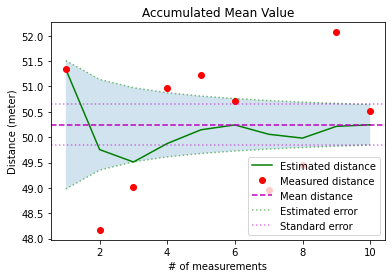

In [2]:
# Compute recursive sample mean (SLSQ)

# Import
from numpy import array, arange, negative, var
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Measurements
z = array([[51.34],
           [48.17],
           [49.02],
           [50.97],
           [51.23],
           [50.72],
           [48.95],
           [49.45],
           [52.07],
           [50.52]])

# number of measurements
N = len(z)

# Measurement variance
sigmaz2 = var(z, ddof=1) 

# Initial state vector
x = array([z[0]])

# Initial cofactor matrix
Q = array([[1]])

# Design matrix
H2 = array([[1]])

# Initialize plot lists
x_all = []; z_all = []; Q_all = []

# Main loop
for k in range(0, N):
    
    # Design matrix
    H1 = ones([k, 1])
    
    # Gain matrix
    K = H2.T@inv(H1.T@H1 + H2.T@H2)
        
    # State vector
    x = x + K@(z[k] - H2@x)
    
    if k > 0:
        
        # Cofactor matrix
        Q = (eye(1) - K@H2)@Q
        
    # Accumulate plot lists
    z_all.append(z[k])
    x_all.append(x)
    Q_all.append(Q)

# Extract plot lists
pos = [x[0, 0] for x in x_all]
meas = [z[0] for z in z_all]
sd = [sqrt(sigmaz2*Q[0, 0]) for Q in Q_all]

print("Measurement        : " + ' '.join(f'{meas:.2f}' for meas in meas))
print("Estimated position : " + ' '.join(f'{pos:.2f}' for pos in pos))

# Defining x-axis
n = arange(1, N + 1)

# Plot results
plt.title('Accumulated Mean Value')
plt.plot(n, pos, color='g', label='Estimated distance')
plt.plot(n, meas, color='r', marker='o', linestyle='none', label='Measured distance')
plt.axhline(y=mu, color='m', linestyle='dashed', label='Mean distance')
plt.xlabel('# of measurements')
plt.ylabel('Distance (meter)')

plt.plot(n, mu + sd, alpha=0.5, color='g', linestyle='dotted', label='Estimated error')
plt.plot(n, mu + negative(sd), alpha=0.5, color='g', linestyle='dotted')
plt.fill_between(n, mu + sd, mu + negative(sd), alpha=0.2)
plt.axhline(y=mu + se, alpha=0.5, color='m', linestyle='dotted',label='Standard error')
plt.axhline(y=mu - se, alpha=0.5, color='m', linestyle='dotted')

plt.legend(loc='lower right')
plt.show()

## Summary
In this chapter we have looked into the basics of linear algebra to form observation equations. One way to solve these equations is through the method of Least Squares (LSQ). The solution provides an generic approach to solving large systems of observation equations.

The LSQ soution gives basically these two simple equations as solution for the unknowns $x$ and the corresponding covariance matrix $\Sigma_x$.

$$
\begin{align}
  x =& (H^T \Sigma_z^{-1} H)^{-1} H^T \Sigma_z^{-1} z\\
  \Sigma_x =& (H^T \Sigma_z^{-1} H)^{-1}\\
\end{align}
$$

The recursive version of LSQ is called SLSQ and can be written as follows.

$$
\begin{align}
  K =& \frac{H_2^T \Sigma_{z_2}^{-1}}{H_1^T \Sigma_{z_1}^{-1} H_1 + H_2^T \Sigma_{z_2}^{-1} H_2}\\
  x_2 =& x_1 + K(z_2 - H_2 x_1)\\
  Q_{x_2} =& (I - K H_2)Q_{x_1}\\
  \Sigma_{x_2} =& \sigma_z^2 \cdot Q_{x_2}\\
\end{align}
$$

Here we have got ourselves the very first introduction to the concept of a *gain matrix*. This matrix essentially weights the contribution from the last measurement with the contribution from all the other measurments in the system. The update is done through adjusting of the current solution based on the weighted contribution from the new measurement. 

Now its about time to move forward towards the *Kalman filter* and thus not only deal with the measurements alone, but also introduce some *system dynamics* and dig into the more advanced topics of filtering...